In [1]:
import pandahouse as ph
import pandas as pd
import numpy as np
import scipy.stats 

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
sns.set(
    font_scale=2,
    style='whitegrid',
    rc={'figure.figsize': (20, 7)}
)

Вспомним что в первой части проекта были проверены гипотезы о равенстве распределений цен за ночь в зависимости от типа жилья. Однако различия не были обнаружены между ценами за номер в отеле и за жильё целиком. Попробуем поподробнее взглянуть на эти типы жилья. Предположим, что распределения цен различаются в зависимости от того, насколько близко к центру города жильё расположено. Попробуем проверить гипотезу о равенстве цен за номер в отеле и за жильё целиком в разрезе того, как далеко от центра города оно находится.

In [3]:
connection = dict(database='default',
                  host='',
                  user='',
                  password='')

In [4]:
# Считаем необходимые данные для жилья типа Hotel room и Entire home/apt
query = """
SELECT
    id,
    listing_url,
    room_type,
    latitude,
    longitude,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM ldn_listings
WHERE review_scores_rating <> '' and price > 0 and room_type IN ('Hotel room', 'Entire home/apt')
ORDER BY id
"""
df = ph.read_clickhouse(query, connection=connection)
df.head()

,id,listing_url,room_type,latitude,longitude,price
0,15400,https://www.airbnb.com/rooms/15400,Entire home/apt,51.48796,-0.16898,100.0
1,17402,https://www.airbnb.com/rooms/17402,Entire home/apt,51.52195,-0.14094,300.0
2,25023,https://www.airbnb.com/rooms/25023,Entire home/apt,51.446870000000004,-0.21874000000000002,65.0
3,36299,https://www.airbnb.com/rooms/36299,Entire home/apt,51.47934,-0.28065999999999997,195.0
4,36986,https://www.airbnb.com/rooms/36986,Entire home/apt,51.53972,-0.05885,80.0


In [5]:
# Проверим типы данных
df.dtypes

id              uint32
listing_url     object
room_type       object
latitude        object
longitude       object
price          float32
dtype: object

In [6]:
# Изменим тип данных долготы и широты
df = df.astype({'latitude': 'float', 'longitude': 'float'})

In [7]:
# Напишем функцию для расчета расстояния жилья от центра Лондона
def haversine(l2, f2, r=6371):
    '''функция возвращает расстояние жилья в километрах, на вход принимает долготу и широту'''
    l1, f1 = -0.12574, 51.5085,
    l1, f1, l2, f2 = list(map(np.radians, (l1, f1, l2, f2)))
    return 2 * r * np.arcsin(((np.sin((f2 - f1) / 2)) ** 2 + np.cos(f1) * np.cos(f2) * (np.sin((l2 - l1) / 2) ** 2)) ** 0.5)

In [40]:
# добавим в датафрейм колонку с вычисленным расстоянием
df['distance'] = haversine(df.longitude.values, df.latitude.values)
df.head()

,id,listing_url,room_type,latitude,longitude,price,distance,log_price,cluster,combination
0,15400,https://www.airbnb.com/rooms/15400,Entire home/apt,51.48796,-0.16898,100.0,3.765063,4.605170,near,Entire home/apt - near
1,17402,https://www.airbnb.com/rooms/17402,Entire home/apt,51.52195,-0.14094,300.0,1.828392,5.703783,near,Entire home/apt - near
2,25023,https://www.airbnb.com/rooms/25023,Entire home/apt,51.44687,-0.21874,65.0,9.404512,4.174387,far,Entire home/apt - far
3,36299,https://www.airbnb.com/rooms/36299,Entire home/apt,51.47934,-0.28066,195.0,11.204482,5.273000,far,Entire home/apt - far
4,36986,https://www.airbnb.com/rooms/36986,Entire home/apt,51.53972,-0.05885,80.0,5.785069,4.382027,near,Entire home/apt - near


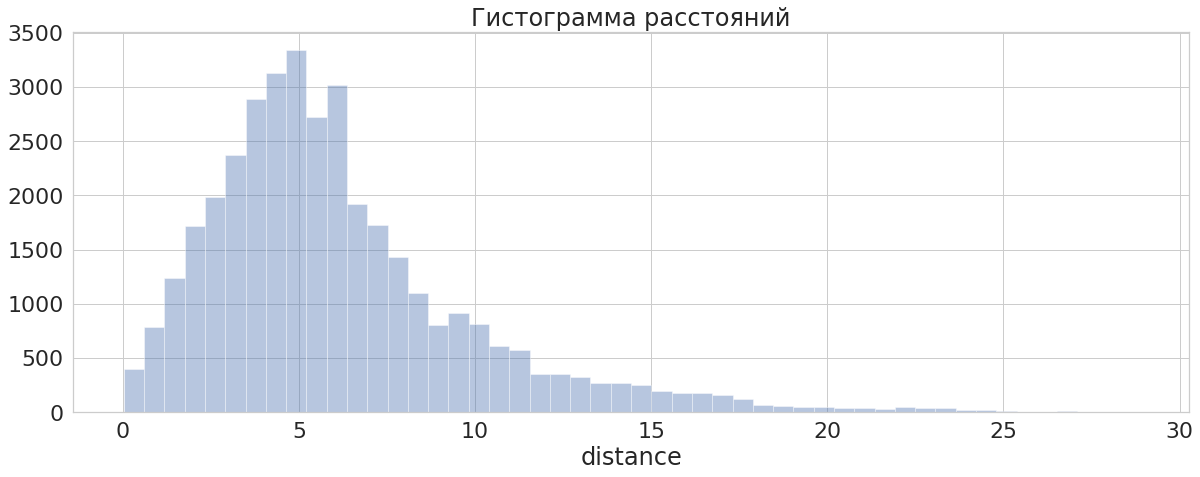

In [9]:
sns.distplot(df.distance, kde=False)
plt.title(f'Гистограмма расстояний');

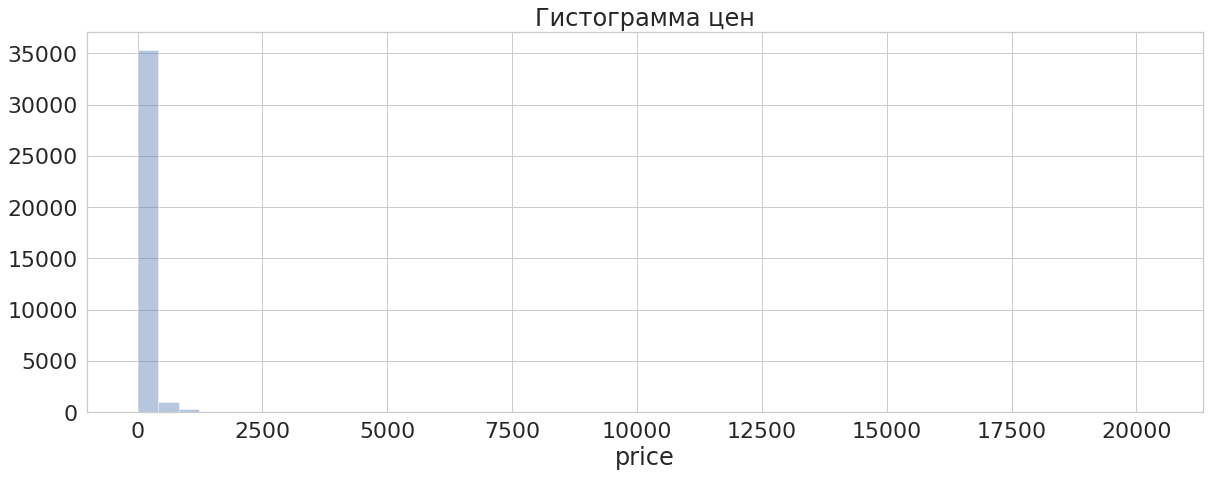

In [10]:
sns.distplot(df.price, kde=False)
plt.title(f'Гистограмма цен');

Видим, что оба распределения скошены вправо, для проверки гипотез будем далее использовать непараметрический критерий Манна-Уитни

In [11]:
df['log_price'] = np.log(df.price)

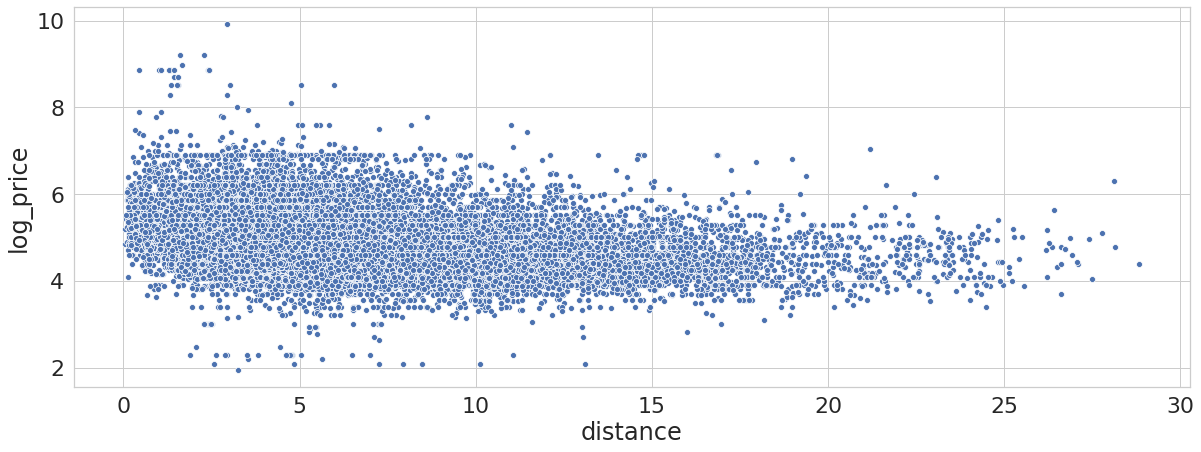

In [12]:
# посмотрит на график
sns.scatterplot(data=df, x="distance", y="log_price")

Визуально можно заметить линейную отрицательную связь. Посчитаем коэффициент корреляции Спирмана 

In [13]:
scipy.stats.spearmanr(df.distance, df.price)

SpearmanrResult(correlation=-0.3267235753221939, pvalue=0.0)

Попробуем кластеризовать объявления, используя информацию о расстоянии от центра города и цене за ночь.

In [14]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2, random_state=42)

In [16]:
model.fit(df[['distance', 'log_price']])

KMeans(n_clusters=2, random_state=42)

In [17]:
df['cluster'] = np.where(model.labels_ == 0, 'near', 'far')

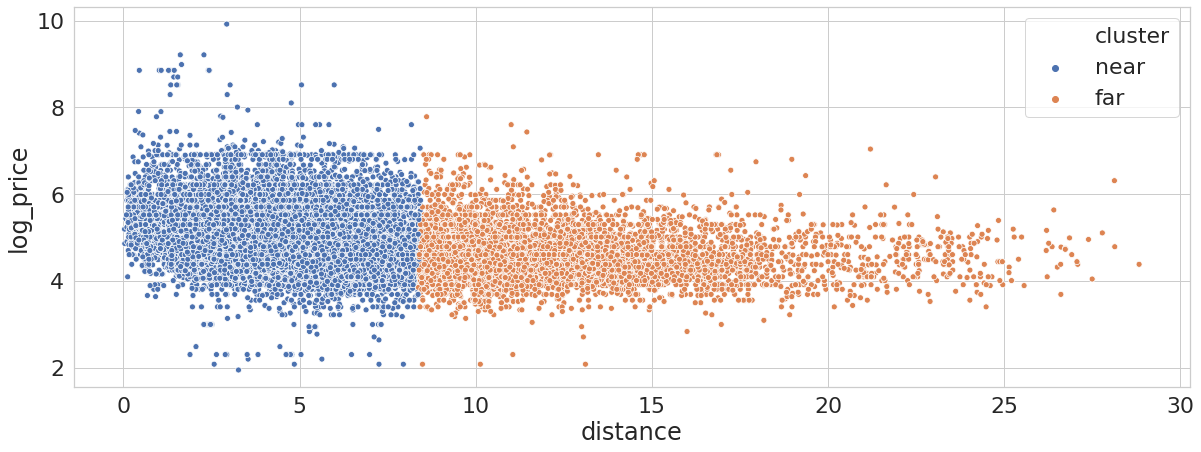

In [19]:
sns.scatterplot(data=df, x="distance", y="log_price", hue='cluster')

In [20]:
df.groupby('cluster', as_index=False) \
    .agg({'price': ['mean', 'median', 'min', 'max'], 'distance': ['mean', 'median', 'min', 'max']})

cluster       price                        distance                       \
                 mean median  min      max       mean     median       min   
0     far  119.955856   95.0  8.0   2400.0  12.217144  11.047882  8.372795   
1    near  165.945511  120.0  7.0  20321.0   4.603660   4.664168  0.030498   

              
         max  
0  28.830617  
1   8.433538

Видим, что объявления были разбиты на 2 кластера, в которых значения описательных статистик, на первый взгляд, значительно отличаются. В кластер far входят объявления, которые расположены дальше от центра города, при этом цены за ночь ниже.

Посмотрим на описательные статистики объявлений в каждой группе (на пересечении типа жилья и кластера).

In [21]:
df.groupby(['cluster', 'room_type'], as_index=False) \
    .agg({'price': ['count', 'mean', 'median', 'std']}) \
    .round(2)

cluster        room_type  price                           
                            count        mean median     std
0     far  Entire home/apt   7230  119.860001   95.0  101.56
1     far       Hotel room    155  124.400002   80.0  165.82
2    near  Entire home/apt  28904  163.610001  120.0  239.35
3    near       Hotel room    421  326.540009  150.0  821.17

Добавим в исходный датафрейм колонку с комбинацией кластера и типа жилья

In [22]:
df['combination'] = df.room_type + ' - ' + df.cluster
df.head()

,id,listing_url,room_type,latitude,longitude,price,distance,log_price,cluster,combination
0,15400,https://www.airbnb.com/rooms/15400,Entire home/apt,51.48796,-0.16898,100.0,3.765063,4.605170,near,Entire home/apt - near
1,17402,https://www.airbnb.com/rooms/17402,Entire home/apt,51.52195,-0.14094,300.0,1.828392,5.703783,near,Entire home/apt - near
2,25023,https://www.airbnb.com/rooms/25023,Entire home/apt,51.44687,-0.21874,65.0,9.404512,4.174387,far,Entire home/apt - far
3,36299,https://www.airbnb.com/rooms/36299,Entire home/apt,51.47934,-0.28066,195.0,11.204482,5.273000,far,Entire home/apt - far
4,36986,https://www.airbnb.com/rooms/36986,Entire home/apt,51.53972,-0.05885,80.0,5.785069,4.382027,near,Entire home/apt - near


Выполним проверку гипотез

In [26]:
from scipy.stats import mannwhitneyu, ttest_ind

In [31]:
mannwhitneyu(df.query("combination == 'Hotel room - far'").price,
             df.query("combination == 'Entire home/apt - far'").price)

MannwhitneyuResult(statistic=458225.0, pvalue=5.032997162381544e-05)

In [32]:
mannwhitneyu(df.query("combination == 'Hotel room - far'").price,
             df.query("combination == 'Entire home/apt - near'").price)

MannwhitneyuResult(statistic=1245790.5, pvalue=6.597222963358506e-22)

In [33]:
mannwhitneyu(df.query("combination == 'Hotel room - near'").price,
             df.query("combination == 'Entire home/apt - far'").price)

MannwhitneyuResult(statistic=1001865.5, pvalue=1.768087953075038e-32)

In [34]:
mannwhitneyu(df.query("combination == 'Hotel room - near'").price,
             df.query("combination == 'Entire home/apt - near'").price)

MannwhitneyuResult(statistic=5131880.0, pvalue=1.6527699589014186e-08)

Во всех случаях p-value < 0.05, следовательно распределения цен Hotel room и Entire home/apt в разбивке по расстоянию от центра города значимо различаются.